# Scaling Laws

During this laboratory we will explore scaling laws, an important part of understanding large models. We will try to replicate some of the results of Training Compute-Optimal Large Language Models (https://arxiv.org/abs/2203.15556). You may find the [slides from the last lecture](https://docs.google.com/presentation/d/1pAeSSmt6jaebXuSI7nJf3EKj2nzldTWlArFkNogtZLs/edit#slide=id.p) helpful.

As the authors of the original paper did not release details of all experiments used to produce the final fit, we will use the data extracted from the plots on this paper by the authors of Chinchilla Scaling: A Replication Attempt (https://arxiv.org/abs/2404.10102). They released their analysis under a github repository (https://github.com/epoch-research/analyzing-chinchilla).

Let's start by loading the data.

In [1]:
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
import torch.optim as optim
from itertools import product
from tqdm.notebook import tqdm

In [2]:
!git clone https://github.com/epoch-research/analyzing-chinchilla

Cloning into 'analyzing-chinchilla'...
remote: Enumerating objects: 30, done.
remote: Counting objects: 100% (30/30), done.
remote: Compressing objects: 100% (22/22), done.
remote: Total 30 (delta 7), reused 21 (delta 5), pack-reused 0 (from 0)
Receiving objects: 100% (30/30), 2.26 MiB | 4.89 MiB/s, done.
Resolving deltas: 100% (7/7), done.


In [41]:
data = pd.read_csv('analyzing-chinchilla/data/svg_extracted_data.csv')

## Exercise 1: Understanding the problem

Take a look into the [Scaling Laws paper](https://arxiv.org/abs/2203.15556) by Hoffmann et al. Read the introduction. Find answers to the following questions/problems in the paper:
  

1.   What is the main research question authors are investigating?
2.   Briefly explain the method taken in Approach 1 (Sec. 3.1).
3.   Briefly explain the method taken in Approach 2 (Sec. 3.2).
4.   Briefly explain the method taken in Approach 3 (Sec 3.3).

Can you identify any advantages or disadvantages of Approach 3 compared to the previous ones?

## Exercise 2: Understanding the data

In this exercise we will examine the data from experiments and make sure they are complete. You may find the function `num_to_readable` (from the cell below) helpful in printing the numbers in human readable format.

In [3]:
def num_to_readable(num):
    if 1e6 <= num < 1e9:
        return f"{num/1e6:.2f}M"
    elif 1e9 <= num < 1e12:
        return f"{num/1e9:.2f}B"
    elif 1e12 <= num < 1e15:
        return f"{num/1e12:.2f}T"
    elif num >= 1e15:
        return f"{num:.5e}"
    elif isinstance(num, float):
        return f"{num:.6}"
    else:
        return f"{num}"

1.   The downloaded data contain columns corresponding to training FLOPs $C$, and model size $N$. Please add a column with dataset size $D$ using a commonly used heuristic for calculating the training cost for Transformers:
$$C=6ND.$$


2.   Examine the data: find the number of experiments, smallest and largest one (in terms of FLOPs), the range of model and dataset sizes.

3.   Let's try to get an idea of the scale of the experiments:

* Calculate the total amount of FLOPs (the sum) in all of them. Compare this value to the FLOPs used to train the main Chinchilla model (you can read the latter value from Figure 1 in the paper).
* According to the [data sheet](https://www.nvidia.com/content/dam/en-zz/Solutions/Data-Center/a100/pdf/nvidia-a100-datasheet-us-nvidia-1758950-r4-web.pdf) of NVIDIA A100, it operates at 312 TFLOPs ($=312\cdot 10^{12}$) per second. Let's imagine we want to replicate the results of the paper by renting A100s in the cloud. Assuming MFU of 50% (that is, effectively our code runs on the GPU at 156 TFLOPs/s), estimate the number of GPU-hours that would be needed to run all of the experiments  in our table and their cost (A100 in the preemptible mode costs around $2/hour).

In [42]:
data['Training FLOP'] = pd.to_numeric(data['Training FLOP'], errors='coerce')
data['Model Size'] = pd.to_numeric(data['Model Size'], errors='coerce')
data['D'] = data['Training FLOP'] / (6 * data['Model Size'])
data['C_readable'] = data['Training FLOP'].apply(num_to_readable)
data['N_readable'] = data['Model Size'].apply(num_to_readable)
data['D_readable'] = data['D'].apply(num_to_readable)

num_experiments = len(data)
print(f"Number of experiments: {num_experiments}")

min_flops = data['Training FLOP'].min()
max_flops = data['Training FLOP'].max()
print(f"Smallest FLOPs: {num_to_readable(min_flops)}")
print(f"Largest FLOPs: {num_to_readable(max_flops)}")

min_N = data['Model Size'].min()
max_N = data['Model Size'].max()
print(f"Model size range: {num_to_readable(min_N)} to {num_to_readable(max_N)}")

min_D = data['D'].min()
max_D = data['D'].max()
print(f"Dataset size range: {num_to_readable(min_D)} to {num_to_readable(max_D)}")

total_flops = data['Training FLOP'].sum()
print(f"Total FLOPs across all experiments: {num_to_readable(total_flops)}")

chinchilla_flops = 1.4e23
print(f"Chinchilla's FLOPs: {num_to_readable(chinchilla_flops)}")

comparison_ratio = total_flops / chinchilla_flops
print(f"Total FLOPs is {comparison_ratio:.2e} times Chinchilla's FLOPs.")

effective_flops_per_sec = 156e12
total_gpu_seconds = total_flops / effective_flops_per_sec
total_gpu_hours = total_gpu_seconds / 3600
cost_per_hour = 2
total_cost = total_gpu_hours * cost_per_hour

print(f"Total GPU-seconds needed: {total_gpu_seconds:.2e} s")
print(f"Total GPU-hours needed: {total_gpu_hours:.2f} hours")
print(f"Total cost at ${cost_per_hour}/hour: ${total_cost:.2f}")

Number of experiments: 245
Smallest FLOPs: 1.39724e+18
Largest FLOPs: 1.29560e+22
Model size range: 57.33M to 16.18B
Dataset size range: 245.11M to 317.75B
Total FLOPs across all experiments: 1.05181e+23
Chinchilla's FLOPs: 1.40000e+23
Total FLOPs is 7.51e-01 times Chinchilla's FLOPs.
Total GPU-seconds needed: 6.74e+08 s
Total GPU-hours needed: 187287.94 hours
Total cost at $2/hour: $374575.89


## Exercise 3: Replicating Approach 2

In this exercise, we will replicate Approach 2: IsoFLOP profiles from the paper.

1. For each budget from the list in the cell below, find the experiments, where
$$|log(\text{experiment_budget})-log(\text{closest_budget_from_list})| < 0.2.$$
We will use only these experiments in the analysis in this exercise.

In [11]:
flop_budgets = [6e18, 1e19, 3e19, 6e19, 1e20, 3e20, 6e20, 1e21, 3e21]

In [12]:
def calculate_closest_budget(budget):
    closest_budget = min(flop_budgets, key=lambda x: abs(x - budget))
    return closest_budget

In [63]:
data['closest_budget'] = data['Training FLOP'].apply(calculate_closest_budget)
data['log_C'] = np.log(data['Training FLOP'])
data['log_budget'] = np.log(data['closest_budget'])
data_filtered = data[abs(data['log_C'] - data['log_budget']) < 0.2]

2. For each budget group, fit a parabola in the log-log scale between number of parameters and loss (i.e. x scale is $log(params)$ and y scale is $log(loss)$, as in the plot from the paper pasted below). Find the minimum of each parabola - this is our estimated optimal model size for each budget group. Plot the points together with the fitted parabolas. Finally, list the estimated optimal number of parameters, training tokens, and corresponding token to parameter ratio for each budget group.

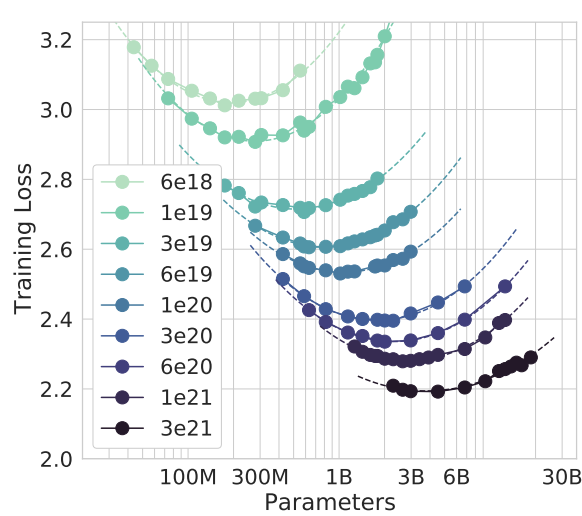

In [64]:
def fit_parabola_and_find_min(group):
    x = np.log(group['Model Size'])
    y = np.log(group['loss'])
    coeffs = np.polyfit(x, y, 2)
    a, b, c = coeffs
    x_min = -b / (2 * a)
    y_min = a * x_min**2 + b * x_min + c
    optimal_model_size = np.exp(x_min)
    predicted_min_loss = np.exp(y_min)
    D = group['Training FLOP'].iloc[0] / (6 * optimal_model_size)
    token_param_ratio = D / optimal_model_size
    return pd.Series({
        'optimal_model_size': optimal_model_size,
        'predicted_min_loss': predicted_min_loss,
        'training_tokens': D,
        'token_param_ratio': token_param_ratio
    })

<ipython-input-65-7633faccf064>:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  results = data_filtered.groupby('closest_budget').apply(fit_parabola_and_find_min).reset_index()


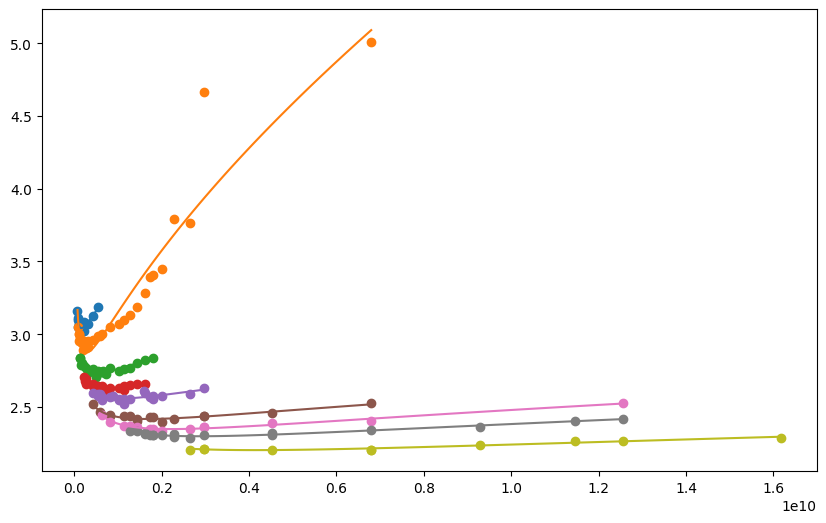

In [65]:
results = data_filtered.groupby('closest_budget').apply(fit_parabola_and_find_min).reset_index()
plt.figure(figsize=(10, 6))
for budget, group in data_filtered.groupby('closest_budget'):
    x = np.log(group['Model Size'])
    y = np.log(group['loss'])
    coeffs = np.polyfit(x, y, 2)
    p = np.poly1d(coeffs)
    x_fit = np.linspace(x.min(), x.max(), 100)
    y_fit = p(x_fit)
    plt.scatter(group['Model Size'], group['loss'], label=f"Budget: {num_to_readable(budget)}")
    plt.plot(np.exp(x_fit), np.exp(y_fit))

In [66]:
results['token_param_ratio'] = results['training_tokens'] / results['optimal_model_size']
results

,closest_budget,optimal_model_size,predicted_min_loss,training_tokens,token_param_ratio
0,6.000000e+18,1.643204e+08,3.041776,5.562465e+09,33.851334
1,1.000000e+19,2.763381e+08,2.872944,6.027551e+09,21.812229
2,3.000000e+19,4.992376e+08,2.730810,9.656498e+09,19.342490
3,6.000000e+19,7.300898e+08,2.626848,1.338137e+10,18.328387
4,1.000000e+20,1.026432e+09,2.556528,1.573577e+10,15.330559
5,3.000000e+20,1.677062e+09,2.416597,2.972556e+10,17.724782
6,6.000000e+20,2.229523e+09,2.347281,4.546448e+10,20.392019
7,1.000000e+21,2.845610e+09,2.297781,5.939027e+10,20.870836
8,3.000000e+21,4.131841e+09,2.202439,1.181419e+11,28.593036


## Exercise 4: Replicating Approach 3

In this exercise we will replicate Approach 3 from the paper: Fitting the Parametric Loss Function. Implement the fitting and fit the final formula. You can find the description of the process in Section 3.3 and D.2 of the paper. Make sure to use a grid of initializations and simply choose the initialization of parameters that allows to minimize RMSE on the data.

In [19]:
N = torch.Tensor(data["Model Size"]).requires_grad_(False)
D = torch.Tensor(data["D"]).requires_grad_(False)
L = torch.Tensor(data["loss"]).requires_grad_(False)

In [20]:
def predict_loss(N, a, alpha, D, b, beta, e):
    return a / N**alpha + b / D**beta + e

In [21]:
def rmse(L, L_pred):
    return torch.sqrt(torch.mean((L - L_pred) ** 2))

In [35]:
def compute_scaling_law(N, a_init, alpha_init, D, b_init, beta_init, e_init, L, huber_delta):
    a = torch.tensor([a_init], dtype=torch.float32, requires_grad=True)
    alpha = torch.tensor([alpha_init], dtype=torch.float32, requires_grad=True)
    b = torch.tensor([b_init], dtype=torch.float32, requires_grad=True)
    beta = torch.tensor([beta_init], dtype=torch.float32, requires_grad=True)
    e = torch.tensor([e_init], dtype=torch.float32, requires_grad=True)

    params = [a, alpha, b, beta, e]
    optimizer = optim.LBFGS(params, history_size=1000, lr=0.01, max_iter=1000, line_search_fn="strong_wolfe")

    def closure():
        optimizer.zero_grad()
        L_pred = predict_loss(N, a, alpha, D, b, beta, e)
        loss = torch.nn.functional.huber_loss(L_pred, L, delta=huber_delta)
        loss.backward()
        return loss

    optimizer.step(closure)

    with torch.no_grad():
        return a.item(), alpha.item(), b.item(), beta.item(), e.item()

In [36]:
import itertools

huber_deltas = [0.001]
alpha_inits = [0.5, 1.0, 1.5]
beta_inits = [0.5, 1.0, 1.5]
a_inits = [5., 10., 15.]
b_inits = [5., 10., 15.]
e_inits = [-0.5, 0., 0.5]

initializations = list(itertools.product(alpha_inits, beta_inits, a_inits, b_inits, e_inits, huber_deltas))

In [37]:
from tqdm import tqdm

results = []

for alpha_init, beta_init, a_init, b_init, e_init, huber_delta in tqdm(initializations):
    try:
        a, alpha, b, beta, e = compute_scaling_law(N, a_init, alpha_init, D, b_init, beta_init, e_init, L, huber_delta)
        L_pred = predict_loss(N, a, alpha, D, b, beta, e)
        current_rmse = rmse(L, L_pred).item()
        results.append({
            'a': a,
            'alpha': alpha,
            'b': b,
            'beta': beta,
            'e': e,
            'rmse': current_rmse
        })
    except Exception as ex:
        continue

100%|██████████| 243/243 [00:28<00:00,  8.67it/s]


Best Parameters:
a: 533.8896484375
alpha: 0.00026216768310405314
b: 361.13446044921875
beta: 0.27672135829925537
e: -528.9486083984375
RMSE: 0.1491626650094986


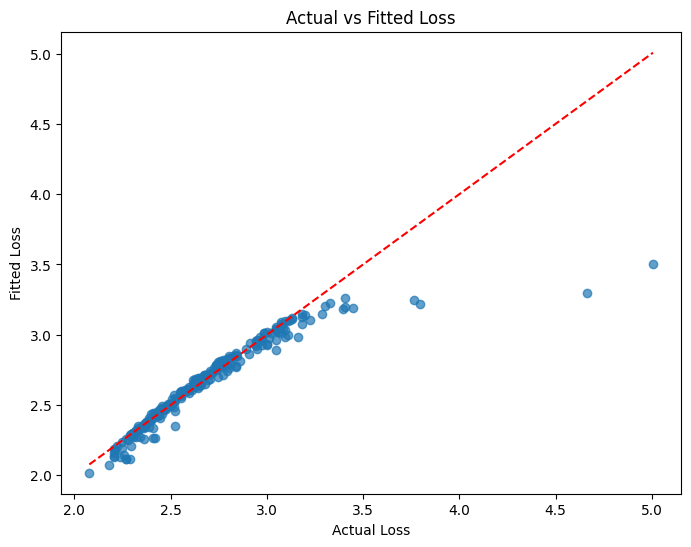

              a     alpha           b      beta           e      rmse
0    533.889648  0.000262  361.134460  0.276721 -528.948608  0.149163
1     10.094566  0.093217   15.013152  0.096605   -0.414815  0.182607
2     15.028216  0.126556   15.001762  0.098717    0.029150  0.184495
3     15.038589  0.127159   15.001763  0.098908    0.048143  0.184592
4     10.013590  0.091438   15.001464  0.098796   -0.380286  0.185436
..          ...       ...         ...       ...         ...       ...
238   10.000000  0.999997   15.000000  1.000000    2.615771  0.368212
239   10.000000  0.999997   10.000000  1.500000    2.615771  0.368212
240   10.000000  0.999997   10.000000  1.000000    2.615771  0.368212
241         NaN       NaN         NaN       NaN         NaN       NaN
242         NaN       NaN         NaN       NaN         NaN       NaN

[243 rows x 6 columns]


In [34]:
results_df = pd.DataFrame(results)

best_params = results_df.loc[results_df['rmse'].idxmin()]
a_best, alpha_best, b_best, beta_best, e_best, rmse_best = best_params

print("Best Parameters:")
print(f"a: {a_best}")
print(f"alpha: {alpha_best}")
print(f"b: {b_best}")
print(f"beta: {beta_best}")
print(f"e: {e_best}")
print(f"RMSE: {rmse_best}")

with torch.no_grad():
    L_fitted = predict_loss(N, a_best, alpha_best, D, b_best, beta_best, e_best)

plt.figure(figsize=(8, 6))
plt.scatter(L.numpy(), L_fitted.numpy(), alpha=0.7)
plt.plot([L.min(), L.max()], [L.min(), L.max()], 'r--')
plt.xlabel('Actual Loss')
plt.ylabel('Fitted Loss')
plt.title('Actual vs Fitted Loss')
plt.show()

sorted_results = results_df.sort_values("rmse").reset_index(drop=True)
print(sorted_results)